# Setup

In [33]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import os

from datetime import datetime
from copy import deepcopy
from torch import nn
from torchvision import transforms
from tqdm import tqdm

from cifar10_utils import get_cifar10, get_dataloader
from models import Bottleneck, ResNet, CBAM, BAM, SEBlock, eca_layer

!pip install grad-cam --quiet
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

ImportError: cannot import name 'SEBlock' from 'models' (/kaggle/usr/lib/models/models.py)

In [19]:
# Seed for reproduceability
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [20]:
def save_model_and_data(name, model, test_accuracy, test_loss, logging_dict):
    os.mkdir(f'./models/{name}')
    torch.save(model, f'./models/{name}/{name}.pt')
    data = {'test_accuracy': test_accuracy,
            'test_loss': test_loss,
            'logging_dict': logging_dict,
            'datetime': datetime.now()}
    with open(f'./models/{name}/{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [21]:
def make_plots(logging_dict, model_name, avg_train=True):
#     logging_dict = {'loss': {'train': [], 'validation': []},
#                 'accuracy': {'train': [], 'validation': []},
#                 'lr': [],
#                 'batches_per_epoch': [],}
    epoch_ends = np.cumsum(logging_dict['batches_per_epoch'])
    
    def get_avg_per_epoch(batch_data):
        result = [None,]
        for i in range(len(epoch_ends) - 1):
            result.append(np.average(batch_data[epoch_ends[i]:epoch_ends[i + 1]]))
        return result
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    metrics = ('loss', 'accuracy')
    for metric, ax in zip(metrics, axes.ravel()):
#         ax.plot(logging_dict[metric]['train'])
        if avg_train:
            ax.plot(get_avg_per_epoch(logging_dict[metric]['train']), '.-', label='training set')
            ax.plot(logging_dict[metric]['validation'], '.-', label='validation set')
            ax.set(title=metric, xlabel='epoch', xticks=np.arange(len(epoch_ends)))
        else:
            ax.plot(logging_dict[metric]['train'],'.-', label='training set')
            ax.plot(epoch_ends, logging_dict[metric]['validation'],'.-', label='validation set')
            ax.set(title=metric, xlabel='batch')
    
    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)
    plt.suptitle(model_name)
    plt.tight_layout()
    plt.show()

## Backbone Architecture

We will use ResNet50 as our backbone architecture.

In [22]:
# Loading the dataset
cifar10 = get_cifar10()
cifar10_loader = get_dataloader(cifar10, batch_size=128,return_numpy=False)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
def evaluate_model(model, data_loader):
    """
    Performs the evaluation of the MLP model on a given dataset.

    Args:
      model: An instance of 'MLP', the model to evaluate.
      data_loader: The data loader of the dataset to evaluate.
    Returns:
        accuracy
    """
    accuracies_per_batch, losses_per_batch = [], []
    loss_module = nn.CrossEntropyLoss()
    # Get accuracy for epoch
    for batch in data_loader:
        
        # Get validation images and labels
        X = batch[0].to(device)
        y = batch[1].to(device)
        
        # Get predictions on validation set
        model.eval()
        with torch.no_grad():
            pred_logits = model.forward(X)
            pred_classes = torch.argmax(torch.softmax(pred_logits, dim=1), axis=1)
        
        # Calculate accuracy := # of correct preds / total # of preds
        current_accuracy = torch.sum(pred_classes == y) / pred_classes.shape[0]
        accuracies_per_batch.append(current_accuracy.item())
        current_loss = loss_module(pred_logits, y).item()
        losses_per_batch.append(current_loss)

    accuracy = np.average(accuracies_per_batch)
    loss = np.average(losses_per_batch)

    return accuracy, loss

In [24]:
def train(model, epochs=15, lr=0.01, momentum=0, verbose=True):
    
    logging_dict = {'loss': {'train': [], 'validation': []},
                    'accuracy': {'train': [], 'validation': []},
                    'lr': [],
                    'batches_per_epoch': [],
                    'momentum': momentum}
    
    for epoch in tqdm(range(epochs)):
        
        batches_per_epoch = 0
        
        model.train()
        
        # Loss module and optimizer
        loss_module = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        
         
        for batch in cifar10_loader['train']:
                        
            batches_per_epoch += 1
            
            # Get training images and labels
            X_train = batch[0].to(device)
            y_train = batch[1].to(device)
            
            # Forward pass
            train_pred_logits = model.forward(X_train)
            
            # Calculate loss
            loss = loss_module(train_pred_logits, y_train)
            logging_dict['loss']['train'].append(loss.item())
            
            # Calculate accuracy
            train_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), axis=1)
            train_accuracy = torch.sum(train_pred_class == y_train) / train_pred_class.shape[0]
            logging_dict['accuracy']['train'].append(train_accuracy.item())
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()

        
        # Log num of batches for this epoch
        logging_dict['batches_per_epoch'].append(batches_per_epoch)
        
        # Log current LR
        logging_dict['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Update LR
        scheduler.step(loss)
        
        # Get metrics on validation set
        validation_accuracy, validation_loss = evaluate_model(model, cifar10_loader['validation'])
        logging_dict['accuracy']['validation'].append(validation_accuracy.item())
        logging_dict['loss']['validation'].append(validation_loss.item())
        
        # Determine if best model
        if len(logging_dict['accuracy']['validation']) == 1 or \
            all([validation_accuracy > acc for acc in logging_dict['accuracy']['validation']]):
            best_model = deepcopy(model)
   
        if verbose:
            print(f'\n{epoch = }, '
                  f'training accuracy: {train_accuracy.item():.3f}, '
                  f'training loss: {loss.item():.3f}',
                  f'validation accuracy: {validation_accuracy.item():.3f}, '
                  f'validation loss: {validation_loss.item():.3f}',
                 )
    
    # Get metrics on test set
    test_accuracy, test_loss = evaluate_model(best_model, cifar10_loader['test'])
    
    return best_model, test_accuracy, test_loss, logging_dict

# Base Models comparison

  7%|▋         | 1/15 [00:42<09:54, 42.43s/it]


epoch = 0, training accuracy: 0.203, training loss: 2.037 validation accuracy: 0.244, validation loss: 2.071


 13%|█▎        | 2/15 [01:24<09:11, 42.39s/it]


epoch = 1, training accuracy: 0.305, training loss: 1.833 validation accuracy: 0.358, validation loss: 1.772


 20%|██        | 3/15 [02:07<08:28, 42.34s/it]


epoch = 2, training accuracy: 0.422, training loss: 1.604 validation accuracy: 0.372, validation loss: 1.732


 27%|██▋       | 4/15 [02:49<07:45, 42.35s/it]


epoch = 3, training accuracy: 0.383, training loss: 1.758 validation accuracy: 0.414, validation loss: 1.639


 33%|███▎      | 5/15 [03:31<07:03, 42.34s/it]


epoch = 4, training accuracy: 0.438, training loss: 1.479 validation accuracy: 0.462, validation loss: 1.473


 40%|████      | 6/15 [04:14<06:21, 42.33s/it]


epoch = 5, training accuracy: 0.414, training loss: 1.379 validation accuracy: 0.454, validation loss: 1.541


 47%|████▋     | 7/15 [04:56<05:38, 42.34s/it]


epoch = 6, training accuracy: 0.477, training loss: 1.534 validation accuracy: 0.467, validation loss: 1.506


 53%|█████▎    | 8/15 [05:38<04:56, 42.35s/it]


epoch = 7, training accuracy: 0.594, training loss: 1.136 validation accuracy: 0.502, validation loss: 1.408


 60%|██████    | 9/15 [06:21<04:14, 42.35s/it]


epoch = 8, training accuracy: 0.688, training loss: 0.926 validation accuracy: 0.498, validation loss: 1.452


 67%|██████▋   | 10/15 [07:03<03:31, 42.35s/it]


epoch = 9, training accuracy: 0.648, training loss: 0.969 validation accuracy: 0.519, validation loss: 1.423


 73%|███████▎  | 11/15 [07:45<02:49, 42.33s/it]


epoch = 10, training accuracy: 0.586, training loss: 1.152 validation accuracy: 0.525, validation loss: 1.447


 80%|████████  | 12/15 [08:28<02:07, 42.35s/it]


epoch = 11, training accuracy: 0.586, training loss: 1.169 validation accuracy: 0.505, validation loss: 1.483


 87%|████████▋ | 13/15 [09:10<01:24, 42.34s/it]


epoch = 12, training accuracy: 0.719, training loss: 0.808 validation accuracy: 0.514, validation loss: 1.535


 93%|█████████▎| 14/15 [09:52<00:42, 42.33s/it]


epoch = 13, training accuracy: 0.727, training loss: 0.834 validation accuracy: 0.511, validation loss: 1.639


100%|██████████| 15/15 [10:35<00:00, 42.35s/it]


epoch = 14, training accuracy: 0.789, training loss: 0.578 validation accuracy: 0.519, validation loss: 1.676


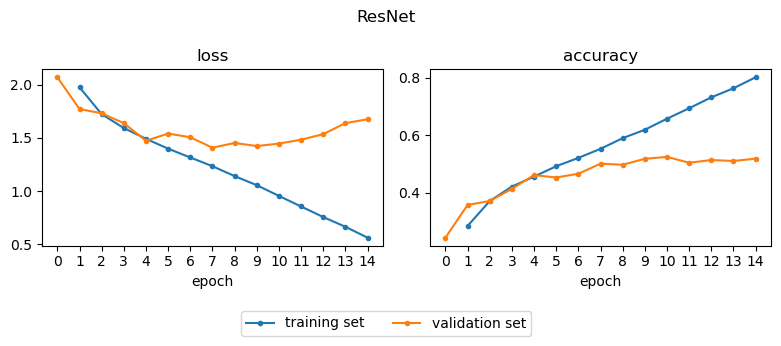

In [25]:
resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], 10).to(device)
resnet_best_model, resnet_test_acc, resnet_test_loss, resnet_logging_dict = train(resnet50)
# %rm -r './models/resnet'
save_model_and_data('resnet', resnet_best_model, resnet_test_acc, resnet_test_loss, resnet_logging_dict)
make_plots(resnet_logging_dict, 'ResNet', avg_train=True)

  7%|▋         | 1/15 [00:56<13:06, 56.20s/it]


epoch = 0, training accuracy: 0.234, training loss: 1.957 validation accuracy: 0.283, validation loss: 1.970


 13%|█▎        | 2/15 [01:52<12:10, 56.21s/it]


epoch = 1, training accuracy: 0.305, training loss: 1.889 validation accuracy: 0.378, validation loss: 1.735


 20%|██        | 3/15 [02:48<11:14, 56.21s/it]


epoch = 2, training accuracy: 0.438, training loss: 1.631 validation accuracy: 0.414, validation loss: 1.592


 27%|██▋       | 4/15 [03:44<10:18, 56.21s/it]


epoch = 3, training accuracy: 0.453, training loss: 1.350 validation accuracy: 0.460, validation loss: 1.495


 33%|███▎      | 5/15 [04:40<09:21, 56.19s/it]


epoch = 4, training accuracy: 0.531, training loss: 1.269 validation accuracy: 0.472, validation loss: 1.452


 40%|████      | 6/15 [05:37<08:25, 56.20s/it]


epoch = 5, training accuracy: 0.523, training loss: 1.349 validation accuracy: 0.486, validation loss: 1.404


 47%|████▋     | 7/15 [06:33<07:29, 56.19s/it]


epoch = 6, training accuracy: 0.523, training loss: 1.256 validation accuracy: 0.489, validation loss: 1.393


 53%|█████▎    | 8/15 [07:29<06:33, 56.19s/it]


epoch = 7, training accuracy: 0.586, training loss: 1.255 validation accuracy: 0.518, validation loss: 1.334


 60%|██████    | 9/15 [08:25<05:37, 56.26s/it]


epoch = 8, training accuracy: 0.625, training loss: 1.129 validation accuracy: 0.520, validation loss: 1.339


 67%|██████▋   | 10/15 [09:22<04:41, 56.24s/it]


epoch = 9, training accuracy: 0.570, training loss: 1.101 validation accuracy: 0.534, validation loss: 1.310


 73%|███████▎  | 11/15 [10:18<03:44, 56.23s/it]


epoch = 10, training accuracy: 0.711, training loss: 0.854 validation accuracy: 0.545, validation loss: 1.312


 80%|████████  | 12/15 [11:14<02:48, 56.22s/it]


epoch = 11, training accuracy: 0.734, training loss: 0.756 validation accuracy: 0.539, validation loss: 1.355


 87%|████████▋ | 13/15 [12:10<01:52, 56.23s/it]


epoch = 12, training accuracy: 0.742, training loss: 0.746 validation accuracy: 0.534, validation loss: 1.413


 93%|█████████▎| 14/15 [13:07<00:56, 56.22s/it]


epoch = 13, training accuracy: 0.805, training loss: 0.513 validation accuracy: 0.527, validation loss: 1.493


100%|██████████| 15/15 [14:03<00:00, 56.22s/it]


epoch = 14, training accuracy: 0.898, training loss: 0.347 validation accuracy: 0.540, validation loss: 1.587


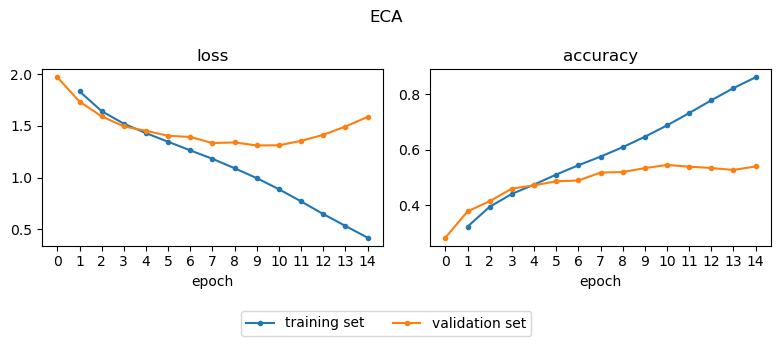

In [26]:
layers = [3, 4, 6, 3]
resnet50_eca = ResNet(Bottleneck,
                       layers,
                       10,
                       extra_modules_list=[[eca_layer(layer * 4 , 3).to(device)] for layer in layers],
                       before_downsampling_list=[[True] for layer in layers]).to(device)
eca_best_model, eca_test_acc, eca_test_loss, eca_logging_dict = train(resnet50_eca)
%rm -r './models/eca'
save_model_and_data('eca', eca_best_model, eca_test_acc, eca_test_loss, eca_logging_dict)
make_plots(eca_logging_dict, 'ECA', avg_train=True)

  7%|▋         | 1/15 [00:59<13:55, 59.65s/it]


epoch = 0, training accuracy: 0.422, training loss: 1.704 validation accuracy: 0.348, validation loss: 1.829


 13%|█▎        | 2/15 [01:59<12:55, 59.63s/it]


epoch = 1, training accuracy: 0.375, training loss: 1.584 validation accuracy: 0.405, validation loss: 1.635


 20%|██        | 3/15 [02:58<11:55, 59.62s/it]


epoch = 2, training accuracy: 0.523, training loss: 1.387 validation accuracy: 0.442, validation loss: 1.536


 27%|██▋       | 4/15 [03:58<10:55, 59.62s/it]


epoch = 3, training accuracy: 0.406, training loss: 1.490 validation accuracy: 0.473, validation loss: 1.455


 33%|███▎      | 5/15 [04:58<09:56, 59.64s/it]


epoch = 4, training accuracy: 0.492, training loss: 1.369 validation accuracy: 0.488, validation loss: 1.399


 40%|████      | 6/15 [05:57<08:56, 59.62s/it]


epoch = 5, training accuracy: 0.547, training loss: 1.296 validation accuracy: 0.508, validation loss: 1.366


 47%|████▋     | 7/15 [06:57<07:57, 59.68s/it]


epoch = 6, training accuracy: 0.648, training loss: 1.131 validation accuracy: 0.523, validation loss: 1.323


 53%|█████▎    | 8/15 [07:57<06:57, 59.64s/it]


epoch = 7, training accuracy: 0.586, training loss: 1.077 validation accuracy: 0.529, validation loss: 1.306


 60%|██████    | 9/15 [08:56<05:57, 59.62s/it]


epoch = 8, training accuracy: 0.703, training loss: 0.975 validation accuracy: 0.531, validation loss: 1.297


 67%|██████▋   | 10/15 [09:56<04:57, 59.59s/it]


epoch = 9, training accuracy: 0.680, training loss: 0.846 validation accuracy: 0.538, validation loss: 1.311


 73%|███████▎  | 11/15 [10:55<03:58, 59.59s/it]


epoch = 10, training accuracy: 0.719, training loss: 0.804 validation accuracy: 0.532, validation loss: 1.310


 80%|████████  | 12/15 [11:55<02:58, 59.57s/it]


epoch = 11, training accuracy: 0.781, training loss: 0.699 validation accuracy: 0.547, validation loss: 1.325


 87%|████████▋ | 13/15 [12:54<01:59, 59.56s/it]


epoch = 12, training accuracy: 0.742, training loss: 0.736 validation accuracy: 0.547, validation loss: 1.351


 93%|█████████▎| 14/15 [13:54<00:59, 59.55s/it]


epoch = 13, training accuracy: 0.805, training loss: 0.592 validation accuracy: 0.546, validation loss: 1.397


100%|██████████| 15/15 [14:53<00:00, 59.59s/it]


epoch = 14, training accuracy: 0.852, training loss: 0.468 validation accuracy: 0.547, validation loss: 1.453


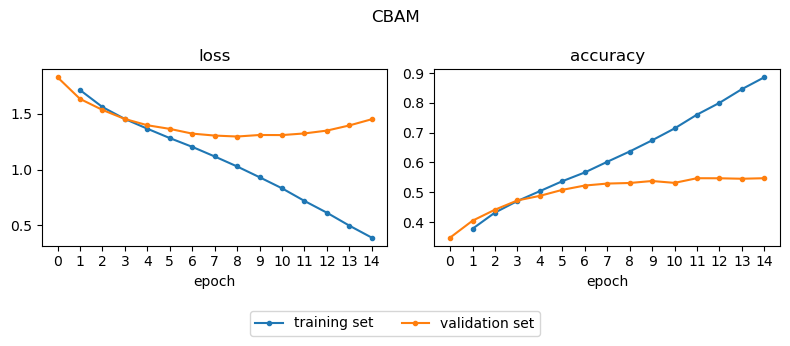

In [27]:
layers = [3, 4, 6, 3]
resnet50_cbam = ResNet(Bottleneck,
                       layers,
                       10,
                       extra_modules_list=[[CBAM(64 * 4).to(device)], [CBAM(128 * 4).to(device)], [CBAM(256 * 4).to(device)], [CBAM(512 * 4).to(device)]],
                       before_downsampling_list=[[False] for layer in layers]).to(device)
cbam_best_model, cbam_test_acc, cbam_test_loss, cbam_logging_dict = train(resnet50_cbam)
%rm -r './models/cbam'
save_model_and_data('cbam', cbam_best_model, cbam_test_acc, cbam_test_loss, cbam_logging_dict)
make_plots(cbam_logging_dict, 'CBAM', avg_train=True)

  7%|▋         | 1/15 [00:46<10:48, 46.29s/it]


epoch = 0, training accuracy: 0.195, training loss: 2.112 validation accuracy: 0.236, validation loss: 2.191


 13%|█▎        | 2/15 [01:32<10:00, 46.21s/it]


epoch = 1, training accuracy: 0.328, training loss: 2.142 validation accuracy: 0.317, validation loss: 2.219


 20%|██        | 3/15 [02:18<09:14, 46.19s/it]


epoch = 2, training accuracy: 0.453, training loss: 1.561 validation accuracy: 0.371, validation loss: 1.734


 27%|██▋       | 4/15 [03:04<08:28, 46.18s/it]


epoch = 3, training accuracy: 0.414, training loss: 1.562 validation accuracy: 0.435, validation loss: 1.573


 33%|███▎      | 5/15 [03:50<07:41, 46.17s/it]


epoch = 4, training accuracy: 0.531, training loss: 1.301 validation accuracy: 0.456, validation loss: 1.516


 40%|████      | 6/15 [04:37<06:55, 46.22s/it]


epoch = 5, training accuracy: 0.477, training loss: 1.370 validation accuracy: 0.474, validation loss: 1.468


 47%|████▋     | 7/15 [05:23<06:09, 46.18s/it]


epoch = 6, training accuracy: 0.461, training loss: 1.398 validation accuracy: 0.485, validation loss: 1.453


 53%|█████▎    | 8/15 [06:09<05:23, 46.24s/it]


epoch = 7, training accuracy: 0.547, training loss: 1.216 validation accuracy: 0.486, validation loss: 1.418


 60%|██████    | 9/15 [06:55<04:37, 46.22s/it]


epoch = 8, training accuracy: 0.594, training loss: 1.085 validation accuracy: 0.475, validation loss: 1.458


 67%|██████▋   | 10/15 [07:42<03:51, 46.20s/it]


epoch = 9, training accuracy: 0.516, training loss: 1.313 validation accuracy: 0.494, validation loss: 1.476


 73%|███████▎  | 11/15 [08:28<03:04, 46.19s/it]


epoch = 10, training accuracy: 0.625, training loss: 1.036 validation accuracy: 0.489, validation loss: 1.460


 80%|████████  | 12/15 [09:14<02:18, 46.17s/it]


epoch = 11, training accuracy: 0.625, training loss: 1.004 validation accuracy: 0.486, validation loss: 1.536


 87%|████████▋ | 13/15 [10:00<01:32, 46.17s/it]


epoch = 12, training accuracy: 0.625, training loss: 1.067 validation accuracy: 0.508, validation loss: 1.503


 93%|█████████▎| 14/15 [10:46<00:46, 46.18s/it]


epoch = 13, training accuracy: 0.688, training loss: 0.868 validation accuracy: 0.499, validation loss: 1.633


100%|██████████| 15/15 [11:32<00:00, 46.19s/it]


epoch = 14, training accuracy: 0.695, training loss: 0.766 validation accuracy: 0.519, validation loss: 1.614


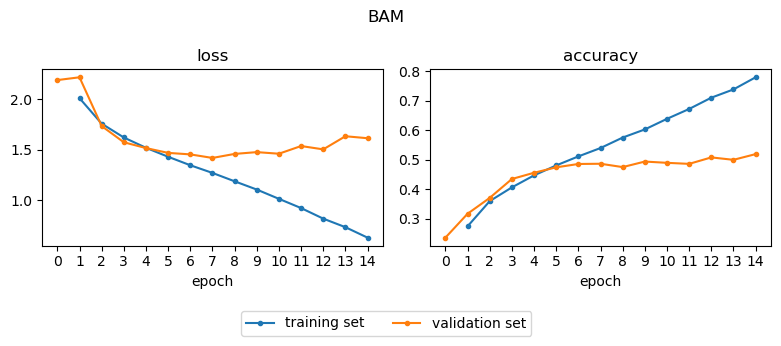

In [28]:
layers = [3, 4, 6, 3]
resnet50_bam = ResNet(Bottleneck,
                       layers,
                       10,
                       extra_modules_per_layer_list=[[BAM(64 * 4).to(device)], [BAM(128 * 4).to(device)], [BAM(256 * 4).to(device)], None]).to(device)
bam_best_model, bam_test_acc, bam_test_loss, bam_logging_dict = train(resnet50_bam)
%rm -r './models/bam'
save_model_and_data('bam', bam_best_model, bam_test_acc, bam_test_loss, bam_logging_dict)
make_plots(bam_logging_dict, 'BAM', avg_train=True)

## GradCAM

Docs: https://jacobgil.github.io/pytorch-gradcam-book/introduction.html

In [29]:
classes_names = {i: c for i, c in enumerate (('airplane', 'automobile', 'bird', 'cat', 'deer',
                                              'dog', 'frog', 'horse', 'ship', 'truck',))}

def show_activations(model, target_layers, image_number: int | None = None, use_cuda=True):
    if image_number == None:
        img, label = cifar10['train'][np.random.randint(350)]
    else:
        img, label = cifar10['train'][image_number]
    input_tensor = img.unsqueeze(0)
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)
    targets = [ClassifierOutputTarget(label)] if label else None
    grayscale_cam = cam(input_tensor, targets)
    grayscale_cam = grayscale_cam[0, :]
    def normalize(img):
        return ((img - img.min()) / (img.max() - img.min()))

    visualization = show_cam_on_image(normalize(torch.permute(img, (1, 2, 0))).numpy(), grayscale_cam, use_rgb=True)

    fig, axs = plt.subplots(1, 2)
    axs = axs.ravel()
    axs[0].imshow(torch.permute(img, (1, 2, 0)))
    axs[0].axis('off')
    axs[1].imshow(visualization)
    axs[1].axis('off')
    plt.suptitle(classes_names[label])


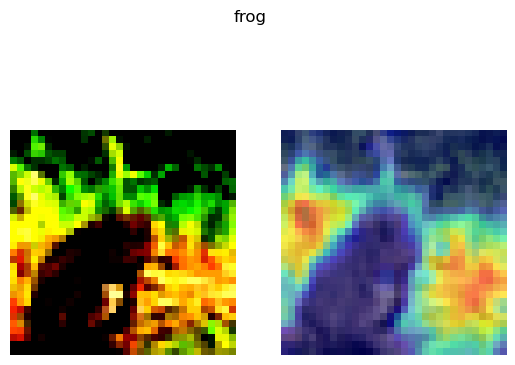

In [30]:
show_activations(model=eca_best_model, target_layers=[eca_best_model.conv1])